In [1]:
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('trustpilot_reviews.csv')
df['date_experience'] = pd.to_datetime(df['date_experience'])
df.head()

,review_title,cust_name,cust_location,cust_reviews,cust_rating,cust_review_text,seller_response,date_experience
0,PERFECTION,Ellen Feibel,US,3,5,First: you had the books I wanted for a gift t...,False,2024-12-14
1,Good book buying experience,Randy,US,2,5,Great communication about my order. Books arri...,False,2024-12-14
2,I appreciate the selection and the…,Nana,US,3,5,I appreciate the selection and the prices of t...,False,2024-12-13
3,The books arrived in a very timely…,customer,US,1,5,The books arrived in a very timely fashion and...,False,2024-12-14
4,"Quick delivery, fab products",customer,GB,8,5,Beautiful books delivered extremely quickly co...,False,2024-12-16


In [4]:
df.dtypes

review_title                object
cust_name                   object
cust_location               object
cust_reviews                 int64
cust_rating                  int64
cust_review_text            object
seller_response               bool
date_experience     datetime64[ns]
dtype: object

In [5]:
df['cust_rating'].value_counts().sort_index()

cust_rating
1    18181
2     7276
3    15215
4     4533
5    94919
Name: count, dtype: int64

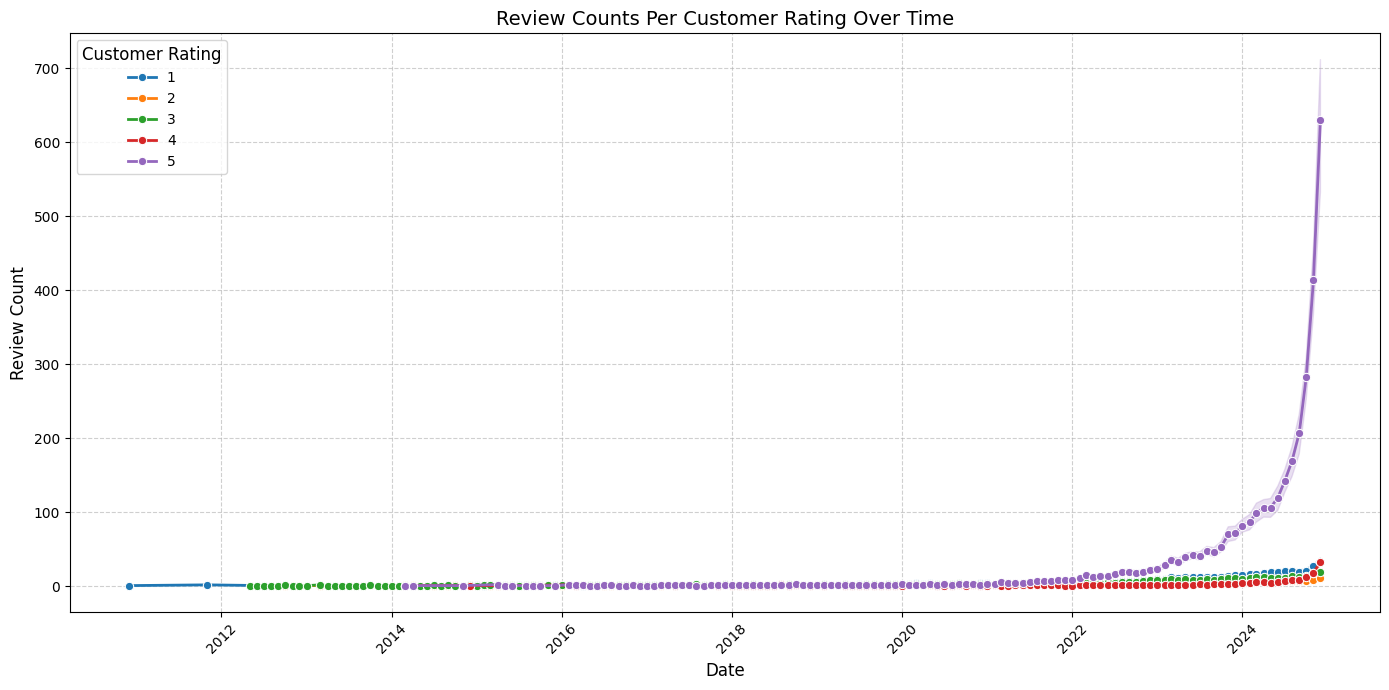

In [6]:
review_counts = df.groupby(['date_experience', 'cust_rating']).size().reset_index(name='review_count')

# Filter to reduce clutter (optional, depends on your dataset)
# For example, aggregate data by month or year to reduce individual points:
review_counts['date_experience'] = review_counts['date_experience'].dt.to_period('M').dt.to_timestamp()

# Create the line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=review_counts,
    x='date_experience',
    y='review_count',
    hue='cust_rating',
    marker='o',
    palette='tab10',
    linewidth=2
)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Counts Per Customer Rating Over Time', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Customer Rating', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()